In [1]:
# Import necessary modules:
from astropy.io import fits

import h5py
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import copy
import pickle
import os
import gc

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K


2025-04-04 13:04:43.068619: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 13:04:43.145923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 13:04:43.558570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 13:04:45.486545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# ------------------------------------------------------------------------------------------------------------

# Flag to remove the young and old clusters:
flag_remove_extremes = False # Currently removing younger than 10^7 years and older than 10^9.5

# Flag to augment or not:
flag_use_augmented = False

# If we are blacking out:
flag_black = True

# Choose the normalization method:
norm_by = "five-images"  # "dataset", "filter, "five-images", single-image"
# normalizing by dataset or by filter makes the weird results because the points values are too different. 
# very small or very large.

# ------------------------------------------------------------------------------------------------------------
# Directories:

# Raw data:
dir_data_raw = "/pool001/vianajr/cluster_ages_1/data/data_raw/raw_phangs_dataset.h5"

# Results parent directory:
dir_results_parent = "/pool001/vianajr/cluster_ages_1/results/single_case/"

# Aux text:
txt_extremes = "yes" if flag_remove_extremes else "no"
txt_augment = "yes" if flag_use_augmented else "no"
# Base prefix for the results directory:
results_prefix = f"single_case_5im_remextremes_{txt_extremes}_augment_{txt_augment}_"

# If we do have blackout:
if flag_black:
    
    # Flag to use the inner or outer region of the circle:
    flag_black_inner = False # If flag_black_inner is True, we are blacking out the center, if Flase black out outer.
    # Define the radius for the blacking:
    R = 6

    # If inner:
    if flag_black_inner: 
        
        # Extension for the paths:
        extension = "inner"
        
        # Parameters for training:
        arr_learn_rates = [0.000001, 0.0000001]
        patience = 30
        arr_epochs = [100, 10] # 100
        batch_size = 16
        
    # If outer: 
    else: 
        # Extension for the paths:
        extension = "outer"
        
        # Parameters for training:
        arr_learn_rates = [0.000001, 0.0000001]
        patience = 30
        arr_epochs = [100, 10] # 100
        batch_size = 16
        
    # Create the folder for these results:
    dir_results = dir_results_parent + results_prefix + f"blackout_{extension}_normby_{norm_by}/R_{R}/"

    
# If no blackout:
else: 

    # Parameters for training:
    arr_learn_rates = [0.000001, 0.0000001]
    patience = 30
    arr_epochs = [120, 10] # 100
    batch_size = 16
        
    # Create the folder for these results:
    dir_results = dir_results_parent + results_prefix + f"blackout_no_normby_{norm_by}/"
    
    
# Create if not exists:
if not os.path.exists(dir_results): os.makedirs(dir_results)

# ------------------------------------------------------------------------------------------------------------

# Number of models per case to get an average of errors:
num_models_per_case = 5

# Flag to plot preliminary data visualization:
flag_plot_data_viz = True

# ------------------------------------------------------------------------------------------------------------
# Display:

print()
print()
print("--------------------------------------")
print("SINGLE -------------------------------")
print("5-im case ----------------------------")
print()
print("Params:")
print()
print("flag_remove_extremes: ", flag_remove_extremes)
print("flag_use_augmented: ", flag_use_augmented)
print()
print("flag_black: ", flag_black)
if flag_black:
    print()
    print("flag_black_inner: ", flag_black_inner)
    print("R: ", R)
print()
print("Normalization by")
print(norm_by)
print()
print("arr_learn_rates: ", arr_learn_rates)
print("arr_epochs: ", arr_epochs)
print("batch_size: ", batch_size)
print("patience: ", patience)
print()
print("--------------------------------------")
print()
print()




--------------------------------------
SINGLE -------------------------------
5-im case ----------------------------

Params:

flag_remove_extremes:  False
flag_use_augmented:  False

flag_black:  True

flag_black_inner:  False
R:  6

Normalization by
five-images

arr_learn_rates:  [1e-06, 1e-07]
arr_epochs:  [100, 10]
batch_size:  16
patience:  30

--------------------------------------




In [3]:

# ------------------------------------------------------------------------------------------------------------
# Set the seed for reproducibility
random_seed = 15
random.seed(random_seed)
np.random.seed(random_seed)  # If you also want to ensure reproducibility with numpy functions

# ------------------------------------------------------------------------------------------------------------
# Class to read the dataset in the format it is:
class ReadPhangsH5:
    
    def __init__(self, hdf5_filename):
        # loading from hdf5 file
        with h5py.File(hdf5_filename, "r") as hf:
            
            # Get the cluster ID:
            self.cluster_ids = np.array(hf["cluster_ids"], dtype=np.int32)
            # Use astype(str) to correctly convert HDF5 string datasets to Python strings, for the galaxy_ids:
            self.galaxy_ids = np.array(hf["galaxy_ids"]).astype(str)
            # Get the image cutouts:
            self.image_cutouts = np.array(hf["image_cutouts"], dtype=np.float32)
            # Get the log of the ages:
            self.cluster_log_ages = np.array(hf["cluster_log_ages"], dtype=np.float32)

    def __getitem__(self, index):
        # Get the image cutouts for the instance (5 images)
        x = self.image_cutouts[index]

        # Get the log of the ages:
        y = self.cluster_log_ages[index]

        return x, y

    def __len__(self):
        return len(self.image_cutouts)

    
# ------------------------------------------------------------------------------------------------------------
# Function to split the input (X) and output (Y) from the dataset
def separate_X_Y(dataset):
    X = [x for x, _ in dataset]
    Y = [y for _, y in dataset]
    return np.array(X), np.array(Y)


# ------------------------------------------------------------------------------------------------------------
# Function to blackout a circle from the center:
def blackout(images, R, flag_black_inner):
    """
    Apply a circular mask blackout to the center of the images with radius R.
    The blackout will be an approximation since the images are 2D matrices.
    
    :param images: A numpy array of shape (n_samples, 5, 112, 112)
    :param R: Radius of the blackout circle (better if it is an odd number)
    :param flag_black_inner: If True we are removing the Inner center of the image, else the outer.
    :return: Modified images with the center blacked out
    """
    # Dimensions of the images
    n_samples, filters, height, width = images.shape # Here shape is: samples, filters, height, widht
    
    # Center of the images
    center_x, center_y = width // 2, height // 2  # For 111x111, this will be 55, 55
    
    # Create a mask with the same dimensions as the image
    y, x = np.ogrid[:height, :width]
    
    # Correct the radius to be applied in a "circle" like pattern
    mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= (R ** 2)
    
    # If we are not blacking out the inner, then we are the outer:
    if not flag_black_inner:
        mask = np.logical_not(mask)
        
    # Show the mask:
    # plt.imshow(mask)

    # Apply the mask to each image in the dataset
    for i in range(n_samples):
        for j in range(filters):
            images[i, j][mask] = 0  # Zero out the masked area
        
    return images


# ------------------------------------------------------------------------------------------------------------
# Define a function to split the data into tr, vl, and ts sets
def split_dataset(N, tr_ratio=0.7, vl_ratio=0.15, seed=42):
    
    # Initialize:
    random.seed(seed)
    indices = list(range(N))
    random.shuffle(indices)
    
    tr_split = int(tr_ratio * N)
    vl_split = int((tr_ratio + vl_ratio) * N)
    
    tr_indices = indices[:tr_split]
    vl_indices = indices[tr_split:vl_split]
    ts_indices = indices[vl_split:]
    
    return tr_indices, vl_indices, ts_indices


# ------------------------------------------------------------------------------------------------------------
# Function to plot 5 heatmaps in a row with different colormaps
def plot_multiple_heatmaps(image_cutouts, num_rows):
    
    # Params:
    num_cols = 5  # Assuming we have 5 columns in the instances
      
    # Initialize the figure:
    plt.figure(figsize=(20, 4 * num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    
    # List of colormaps
    colormaps = ["twilight_shifted", "terrain", "BrBG", "PRGn_r", "coolwarm"]
    
    for row in range(num_rows):
        # Loop through the slices of the instance:
        for i in range(num_cols):
            # Plot in the axes[row, i]
            sns.heatmap(image_cutouts[row, i, :, :], cmap=colormaps[i], cbar=False, ax=axes[row, i])
            axes[row, i].set_title(f"Image {i + 1}")
            axes[row, i].axis('off')  # Turn off axis

    plt.tight_layout()
    plt.savefig(dir_results + "1_heatmaps_indiv_instances.png")
    plt.show()
    
      
# ------------------------------------------------------------------------------------------------------------
def plot_multiple_histograms(image_cutouts, num_rows, suffix):
    
    num_cols = 5  # Assuming we are showing 5 images per instance
    plt.figure(figsize=(20, 4 * num_rows))
    
    # Initialize the figure:
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    
    for row in range(num_rows):
        for i in range(num_cols):
            # Flatten the image to create a histogram of pixel values
            axes[row, i].hist(image_cutouts[row, i].flatten(), bins=50, color='purple', edgecolor='black', alpha=0.7)
            axes[row, i].set_title(f"Image {i + 1} Histogram")
            axes[row, i].set_xlabel("Pixel Value")
            axes[row, i].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.savefig(dir_results + f"2_histograms_indiv_instances_{suffix}.png")
    plt.show()

    
# ------------------------------------------------------------------------------------------------------------
# Function to plot age values across different datasets with fixed titles and colors
def plot_age_histograms(Y_data, suffix, bins=30):
    """
    Plots histograms of age values across different datasets with fixed titles and colors.
    
    Parameters:
    - Y_data: List of Y values (e.g., [Y_tr, Y_vl, Y_ts]).
    - bins: Number of bins for the histograms (default=30).
    """
    # Define fixed titles and colors
    titles = ['Training Set', 'Validation Set', 'Test Set']
    colors = ['blue', 'green', 'red']
    
    # Create subplots
    fig, axes = plt.subplots(1, len(Y_data), figsize=(15, 5))
    
    # Plot histograms
    for ax, Y, title, color in zip(axes, Y_data, titles, colors):
        ax.hist(Y, bins=bins, color=color, edgecolor='black', alpha=0.7)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Cluster Log Ages', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(dir_results + f"3_histograms_outputs_{suffix}.png")
    plt.show()
    
    
# ------------------------------------------------------------------------------------------------------------
# Function to augment a dataset by creating 8 versions 4 rotations and reversed 4 totations:
def augment_dataset_full(data):
    
    # The actual augmented data:
    aug_data = []
    # Reference for the past indexes that they corresponded to:
    aug_past_idxs = [] 
    
    for i, (x, y) in enumerate(data):

        # Original + 90° rotations
        for i in range(4):
            
            # Rotate 0°, 90°, 180°, 270°
            rot_x = np.array([ np.rot90(image, k=i) for image in x ])
            
            # Increase data:
            aug_data.append( (rot_x, y) )  
            aug_past_idxs.append(i)
        
        # Flip the image (up-down flip)
        flip_x = np.array([ np.flipud(image) for image in x ])
        
        # Flipped + 90° rotations
        for i in range(4):
            # Rotate flipped image
            rot_flip_x = np.array([ np.rot90(flip_image, k=i) for flip_image in flip_x ])
            # Increase data:
            aug_data.append( (rot_flip_x, y) )  
            aug_past_idxs.append(i)


    return aug_data, aug_past_idxs


# ------------------------------------------------------------------------------------------------------------
# Plotting function for visualizing the  data
def plot_first_instances(input_data, suffix, num_rows=4, num_cols=5):

    # Initialize the figure:
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

    # Loop through each row (instance):
    for i in range(num_rows):
        # Get the data (x contains the 5 images, y_label is the label for that instance):
        x_ims, y_label = input_data[i]

        # Plot the 5 images for the current instance (i.e., for one instance)
        for j in range(num_cols):
            # Display the image (assuming x_ims contains 5 images, we display the j-th image)
            axes[i, j].imshow(x_ims[j], cmap="gray")  # Display j-th image in the row
            axes[i, j].axis('off')  # Hide axis

            # Add a title to each subplot showing the value of y
            axes[i, j].set_title(f"y = {y_label}", fontsize=16)

        # Add a row label for the instance
        axes[i, 0].set_ylabel(f'Instance {i+1}', fontsize=12, rotation=0, labelpad=80)

    # Ensure layout is tidy and titles/labels are visible
    plt.tight_layout()
    plt.savefig(dir_results + f"4_indiv_instances_post_augm_{suffix}.png")
    plt.show()


# ------------------------------------------------------------------------------------------------------------
# Function to create model with a single branch for all 5-channel images
def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))  # Single output for predicting log age
    return model

# ------------------------------------------------------------------------------------------------------------
# Results plots:

# Plot loss over epochs:
def plot_loss_over_epochs(loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(dir_results_model_k + f"5_losses_evolution.png")
    plt.show()
    
# Function to plot predicted vs true values
def plot_pred_vs_true(y_true, y_pred, title, which_set):

    # Initialize:
    plt.figure(figsize=(6, 6))
    
    # Scatter plot with alpha blending and small markers to match the look
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='none', color='steelblue', label='Cluster stamps', s=18)
    
    # Red dashed line for perfect prediction
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect prediction')
    
    # Labels and title
    plt.xlabel('True log(age) [yrs]', fontsize=12)
    plt.ylabel('Predicted log(age) [yrs]', fontsize=12)
    plt.title(title, fontsize=14)
    
    # Add a legend
    plt.legend(loc='upper left', fontsize=12)
    
    # Set axis limits to be square like the example
    plt.xlim([y_true.min(), y_true.max()])
    plt.ylim([y_true.min(), y_true.max()])
    
    # Add grid lines
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(dir_results_model_k + f"6_pred_vs_true_{which_set}.png")
    plt.show()


# ------------------------------------------------------------------------------------------------------------
# Custom median absolute error metric using numpy
def custom_median_absolute_error(dnrm_y_pred, dnrm_y_true):
    
    # Convert tensors to numpy arrays
    abs_diff = tf.abs(dnrm_y_true - dnrm_y_pred)
    # Use numpy to calculate the median and multiply by 1.49
    median_abs_diff = np.median(abs_diff.numpy())  # Convert tensor to numpy and compute the median
    return 1.49 * median_abs_diff


# ------------------------------------------------------------------------------------------------------------
def add_positional_encoding(X):
    """
    Adds 2D positional encodings to a batch of 5-channel images.
    Input shape: (n_samples, height, width, 5)
    Output shape: (n_samples, height, width, 7)
    """
    n_samples, height, width, _ = X.shape

    # Create normalized positional encodings
    y_coords = np.linspace(0, 1, height).reshape(1, height, 1, 1)
    x_coords = np.linspace(0, 1, width).reshape(1, 1, width, 1)

    # Broadcast to match shape
    y_encoding = np.tile(y_coords, (n_samples, 1, width, 1))  # (n, h, w, 1)
    x_encoding = np.tile(x_coords, (n_samples, height, 1, 1)) # (n, h, w, 1)

    # Concatenate to form final input
    return np.concatenate([X, x_encoding, y_encoding], axis=-1)



X.shape:  (8651, 5, 112, 112)

Shape of X_tr: (6055, 5, 112, 112)
Shape of X_vl: (1298, 5, 112, 112)
Shape of X_ts: (1298, 5, 112, 112)

Shape of Y_tr: (6055,)
Shape of Y_vl: (1298,)
Shape of Y_ts: (1298,)



<Figure size 2000x1600 with 0 Axes>

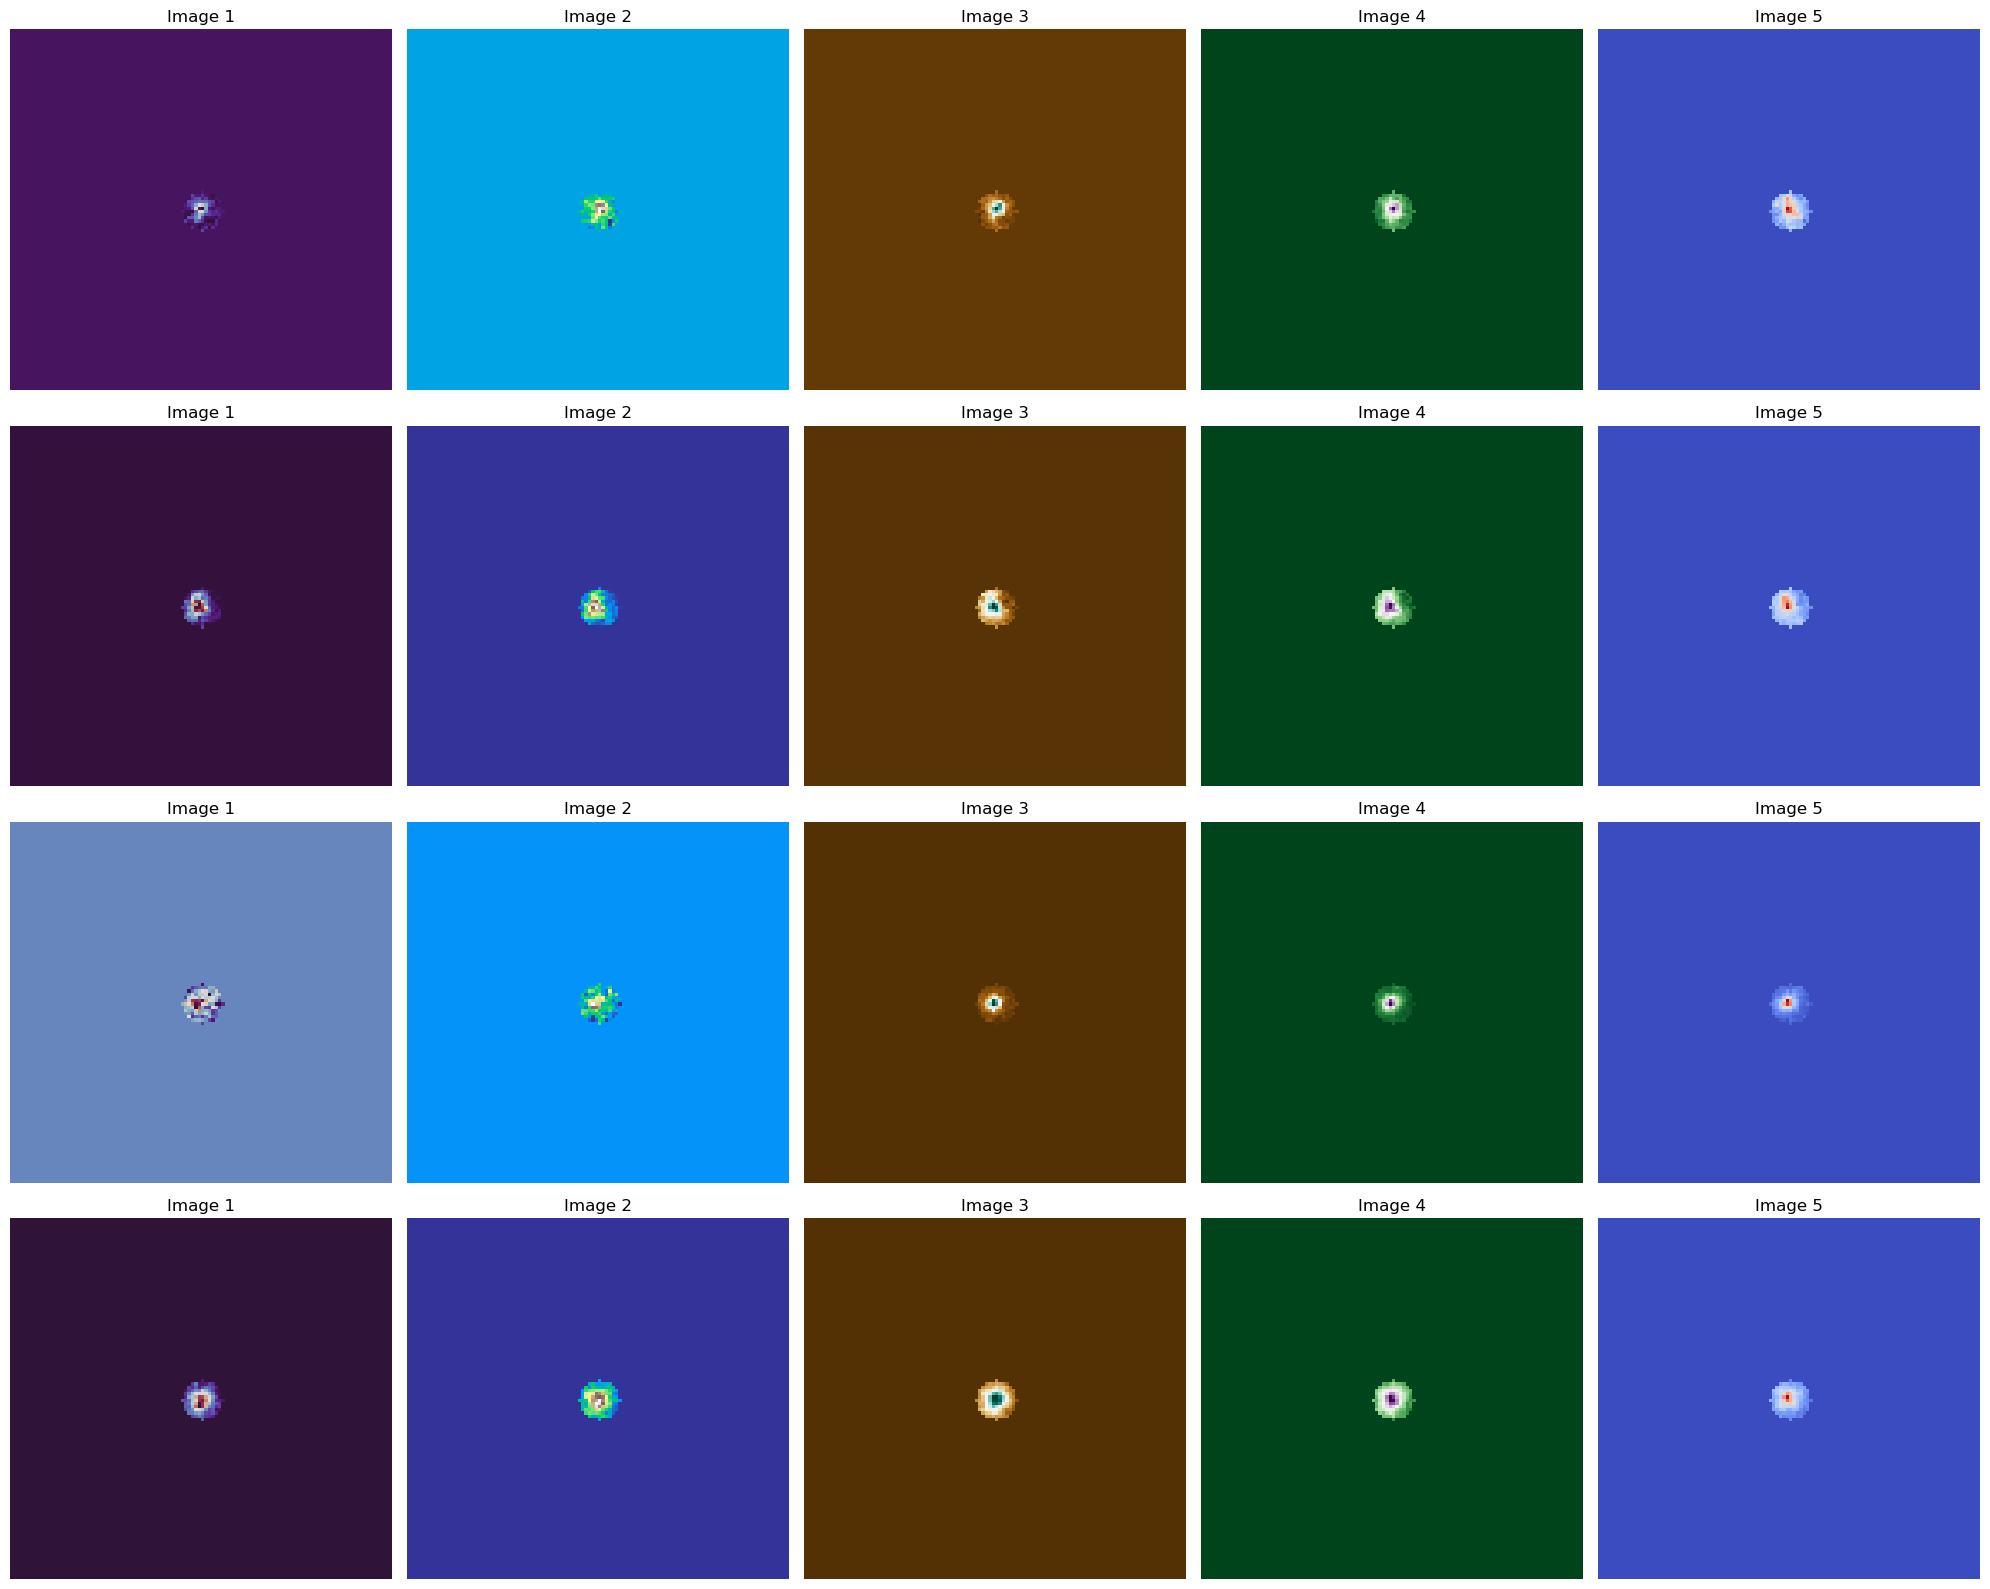

<Figure size 2000x1600 with 0 Axes>

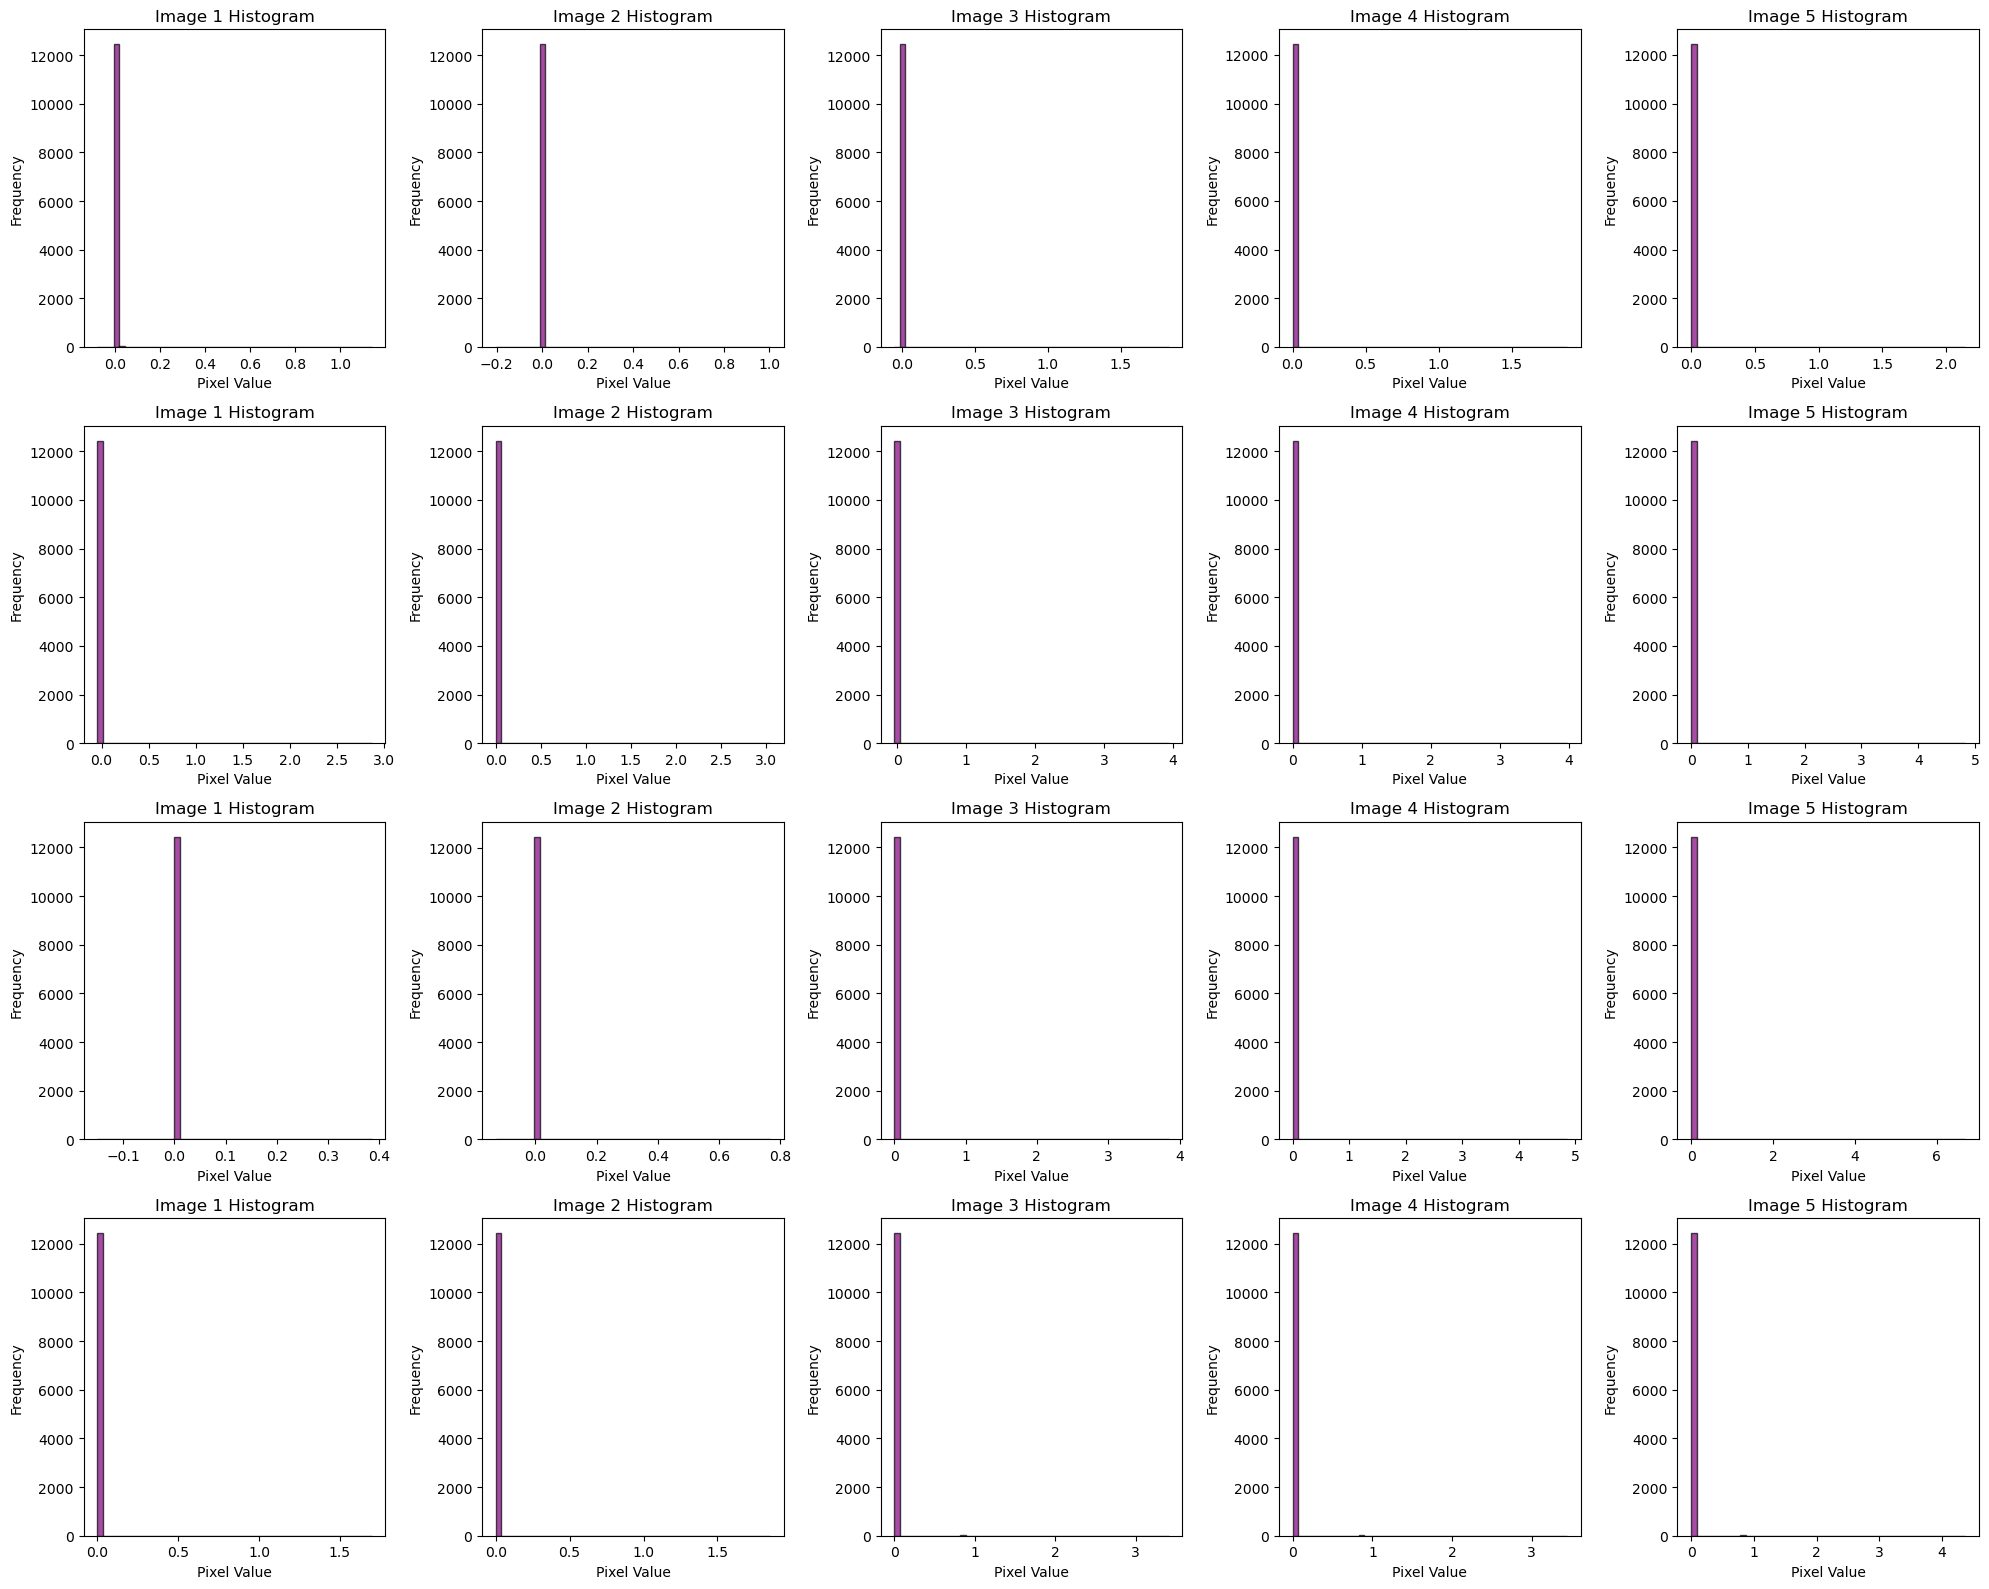

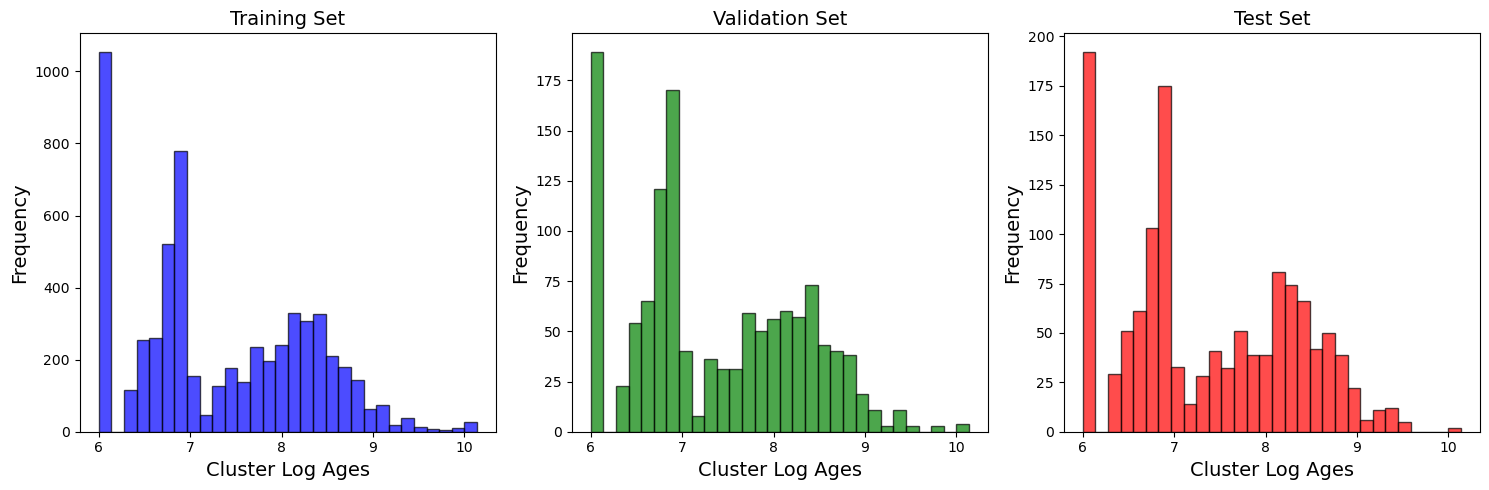

Shape of use_X_tr: (6055, 112, 112, 5)
Shape of use_X_vl: (1298, 112, 112, 5)
Shape of use_X_ts: (1298, 112, 112, 5)

Shape of use_Y_tr: (6055,)
Shape of use_Y_vl: (1298,)
Shape of use_Y_ts: (1298,)



In [4]:
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------

# Start running the code

# Create an instance of the dataset class
raw_dataset = ReadPhangsH5(dir_data_raw)

# Get X and Y:
raw_X, raw_Y = separate_X_Y(raw_dataset)
# Display:
print("X.shape: ", raw_X.shape)
print()

# Get the list of cluster ids and galaxy ids:
raw_clust_ids = raw_dataset.cluster_ids
raw_galax_ids = raw_dataset.galaxy_ids
    
# Remove instances where Y is less than 7 or bigger than 9.5 if flag_remove_extremes is True
if flag_remove_extremes:
    
    # Mask:
    mask = (raw_Y >= 7) & (raw_Y <= 9.5)
    
    # Apply mask to get the curated sets:
    cur_X = raw_X[mask]
    cur_Y = raw_Y[mask]
    # Update the ids:
    cur_clust_ids = raw_clust_ids[mask]
    cur_galax_ids = raw_galax_ids[mask]
    
    # Display:
    print("New X.shape after removing young clusters: ", cur_X.shape)
    print()

# Otherwise simple assignation:
else:
    # Update the data:
    cur_X = raw_X
    cur_Y = raw_Y
    # Update the ids:
    cur_clust_ids = raw_clust_ids
    cur_galax_ids = raw_galax_ids

# Get tr, vl, and ts indices
tr_indices, vl_indices, ts_indices = split_dataset(len(cur_Y))

# ------------------------------------------------------------------------------------------------------------

# If we are working with the blacked dataset:
if flag_black:
    
    # Get the black set:
    blck_X = blackout(cur_X, R, flag_black_inner)
    # Group the blacked data together:
    blck_dataset = [ [x, y] for x, y in zip(blck_X, cur_Y) ]
    # Update the chosen dataset:
    chosen_dataset = blck_dataset

# If not:
else:
    
    # Group the blacked data together:
    normal_dataset = [ [x, y] for x, y in zip(cur_X, cur_Y) ]
    # Then simply the raw_dataset:
    chosen_dataset = normal_dataset


# ------------------------------------------------------------------------------------------------------------
# Now access the data
tr_data = [chosen_dataset[i] for i in tr_indices]
vl_data = [chosen_dataset[i] for i in vl_indices]
ts_data = [chosen_dataset[i] for i in ts_indices]

# Get X and Y for tr, vl, and ts sets using the separate_X_Y function
X_tr, Y_tr = separate_X_Y(tr_data)
X_vl, Y_vl = separate_X_Y(vl_data)
X_ts, Y_ts = separate_X_Y(ts_data)

# Print the shapes of the data
print(f"Shape of X_tr: {X_tr.shape}")
print(f"Shape of X_vl: {X_vl.shape}")
print(f"Shape of X_ts: {X_ts.shape}")
print()
print(f"Shape of Y_tr: {Y_tr.shape}")
print(f"Shape of Y_vl: {Y_vl.shape}")
print(f"Shape of Y_ts: {Y_ts.shape}")
print()

# Get the ids for the sets:
# Cluster ids:
tr_clust_ids = [cur_clust_ids[i] for i in tr_indices]
vl_clust_ids = [cur_clust_ids[i] for i in vl_indices]
ts_clust_ids = [cur_clust_ids[i] for i in ts_indices]
# Galaxy ids:
tr_galax_ids = [cur_galax_ids[i] for i in tr_indices]
vl_galax_ids = [cur_galax_ids[i] for i in vl_indices]
ts_galax_ids = [cur_galax_ids[i] for i in ts_indices]


# ------------------------------------------------------------------------------------------------------------
# Regardless of which set we use for training, for evaluation purposes we want to have two subsets of the data:
#
#     Inner: Data inside the limits, without the extremes (young and old stars)
#     Outer: Data in the extremes (excluding inner)

# Get the masks:
msk_subset_inner = (raw_Y >= 7) & (raw_Y <= 9.5)
msk_subset_outer = ~ msk_subset_inner

# First, you actually need to get the blacked X of all the instances:
if flag_black: treated_all_X = blackout(raw_X, R, flag_black_inner)
else: treated_all_X = raw_X

# Apply the masks to treated_all_X, raw_Y, clust_ids and galax_ids:
subset_outer_X = treated_all_X[msk_subset_outer]
subset_inner_X = treated_all_X[msk_subset_inner]

subset_outer_Y = raw_Y[msk_subset_outer]
subset_inner_Y = raw_Y[msk_subset_inner]

subset_outer_clust_ids = raw_clust_ids[msk_subset_outer]
subset_inner_clust_ids = raw_clust_ids[msk_subset_inner]

subset_outer_galax_ids = raw_galax_ids[msk_subset_outer]
subset_inner_galax_ids = raw_galax_ids[msk_subset_inner]

# CAREFUL: You must get the test points of each subset, you cannot pick any from the training set.
# We will proceed by creating a unique identifier of each instance, then seeing which are both in the ts and the subset.

# Function to create a unique identifier for each instance based on the cluster and the galaxy id:
def create_unique_ids(clust_ids, galax_ids):
    return [str(a) + b for a, b in zip(clust_ids, galax_ids)]

# Obtain the unique identifiers
ts_unique_ids = create_unique_ids(ts_clust_ids, ts_galax_ids)
subset_outer_unique_ids = create_unique_ids(subset_outer_clust_ids, subset_outer_galax_ids)
subset_inner_unique_ids = create_unique_ids(subset_inner_clust_ids, subset_inner_galax_ids)

# Find matching unique IDs
matching_ts_and_outer_ids = set(ts_unique_ids) & set(subset_outer_unique_ids)
matching_ts_and_inner_ids = set(ts_unique_ids) & set(subset_inner_unique_ids)

# If we are removing the extremes, then matching_ts_and_outer_ids is empty:
if flag_remove_extremes: matching_ts_and_outer_ids = set(subset_outer_unique_ids)
    
# Select 600 points from matching IDs - We specify 600 for the test set, to make sure all comparisons are fair among all cases:
matching_ts_and_outer_indices = np.random.choice(list(matching_ts_and_outer_ids), 600, replace=False)
matching_ts_and_inner_indices = np.random.choice(list(matching_ts_and_inner_ids), 600, replace=False)

# Create boolean masks
ts_msk_subset_outer = np.isin(subset_outer_unique_ids, matching_ts_and_outer_indices)
ts_msk_subset_inner = np.isin(subset_inner_unique_ids, matching_ts_and_inner_indices)

# Finally get the evaluation subsets of both X and Y:
ts_subset_outer_X = subset_outer_X[ts_msk_subset_outer]
ts_subset_inner_X = subset_inner_X[ts_msk_subset_inner]
# Don't forget to ravel the Ys:
ts_subset_outer_Y = np.ravel(subset_outer_Y[ts_msk_subset_outer])
ts_subset_inner_Y = np.ravel(subset_inner_Y[ts_msk_subset_inner])

# ------------------------------------------------------------------------------------------------------------

# If we want plotting for preliminary data visualization:
if flag_plot_data_viz:
    
    # Plot the first 4 instances:
    plot_multiple_heatmaps(X_tr, 4)
    
    # Visualize the histograms for the first 4 instances:
    plot_multiple_histograms(X_tr, 4, "unnormed")
    
    # Plot the Age values accross the datasets:
    plot_age_histograms([Y_tr, Y_vl, Y_ts], "unnormed")

# ------------------------------------------------------------------------------------------------------------

# If we want to augment the data:
if flag_use_augmented: 

    # Augmenting training data, and get the new indexesL
    aug_tr_data, aug_tr_past_idxs = augment_dataset_full(tr_data)

    # Print the new length of the augmented dataset
    print(f"Original tr. dataset length: {len(tr_data)}")
    print(f"Aug tr. dataset length: {len(aug_tr_data)}")

    # Plot the first 4 instances (first 4 rows) of the augmented data
    if flag_plot_data_viz: plot_first_instances(aug_tr_data, "unshuffled", num_rows=4, num_cols=5)
    
    # Extract X and Y from the augmented training data
    aug_X_tr, aug_Y_tr = separate_X_Y(aug_tr_data)

    # Create an array of shuffled reference indices 
    aug_tr_shufled_ref_idxs = np.arange(len(aug_X_tr))
    np.random.shuffle(aug_tr_shufled_ref_idxs)

    # Use the shuffled indices to create the final use_X_tr and use_Y_tr
    use_X_tr = aug_X_tr[aug_tr_shufled_ref_idxs]
    use_Y_tr = np.ravel(aug_Y_tr[aug_tr_shufled_ref_idxs]) # For the Ys make sure you ravel them first
    # The ids using the new order of the idxs and retrieving it from the past idxs:
    use_tr_clust_ids = [tr_clust_ids[aug_tr_past_idxs[i]] for i in aug_tr_shufled_ref_idxs] 
    use_tr_galax_ids = [tr_galax_ids[aug_tr_past_idxs[i]] for i in aug_tr_shufled_ref_idxs] 

    # If we have the plotting flag of individual instances activated:
    if flag_plot_data_viz: plot_first_instances(aug_tr_data, "shuffled", num_rows=10, num_cols=5)
            
# If we are not augmenting, the variables we are using are directly these:
else: 
    
    # X and Y:
    use_X_tr = X_tr
    use_Y_tr = np.ravel(Y_tr) 
    # The ids:
    use_tr_clust_ids = tr_clust_ids 
    use_tr_galax_ids = tr_galax_ids


# The vl and ts Xs:
use_X_vl = X_vl
use_X_ts = X_ts
# The vl and ts Ys:
use_Y_vl = np.ravel(Y_vl)
use_Y_ts = np.ravel(Y_ts)
# The ids:
use_vl_clust_ids = vl_clust_ids
use_ts_clust_ids = ts_clust_ids
use_vl_galax_ids = vl_galax_ids
use_ts_galax_ids = ts_galax_ids


# Rearrange the shape of the inputs, so the channels/filters is the last dimension, now (n, 112, 112, 5)
use_X_tr = np.stack([use_X_tr[:, i, :, :] for i in range(5)], axis=-1)
use_X_vl = np.stack([use_X_vl[:, i, :, :] for i in range(5)], axis=-1)
use_X_ts = np.stack([use_X_ts[:, i, :, :] for i in range(5)], axis=-1)

ts_subset_outer_X = np.stack([ts_subset_outer_X[:, i, :, :] for i in range(5)], axis=-1)
ts_subset_inner_X = np.stack([ts_subset_inner_X[:, i, :, :] for i in range(5)], axis=-1)


# Print the shapes of the data
print(f"Shape of use_X_tr: {use_X_tr.shape}")
print(f"Shape of use_X_vl: {use_X_vl.shape}")
print(f"Shape of use_X_ts: {use_X_ts.shape}")
print()
print(f"Shape of use_Y_tr: {use_Y_tr.shape}")
print(f"Shape of use_Y_vl: {use_Y_vl.shape}")
print(f"Shape of use_Y_ts: {use_Y_ts.shape}")
print()


Before Positional Embedding:

nrm_X_tr.shape
(6055, 112, 112, 5)

nrm_X_tr.shape
(6055, 112, 112, 5)

After Positional Embedding:

nrm_X_tr.shape
(6055, 112, 112, 7)

nrm_X_tr.shape
(6055, 112, 112, 7)



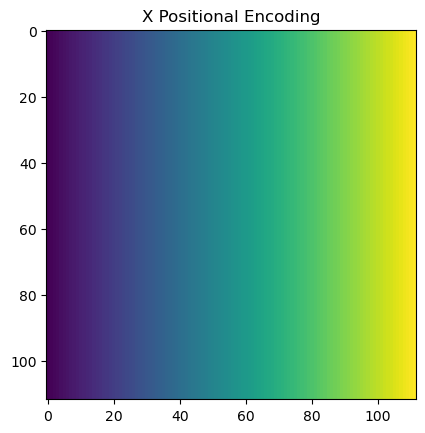

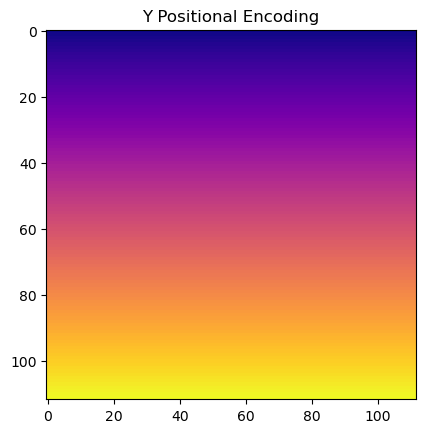

In [5]:

# ------------------------------------------------------------------------------------------------------------
# Data Normalization:



# For both the input normalization or standardization we could group the data differently before taking the
#
#     min & max:   for the normalization
#    mean & stdv:  for the standardization
#
# Below are all the possible groupings we can perform:

# "dataset":
#  ▢ ▢ ▢ ▢ ▢
#  ▢ ▢ ▢ ▢ ▢
#     ...
#  ▢ ▢ ▢ ▢ ▢

# "filter":
#     ▢
#     ▢
#    ...
#     ▢

# "five-images":
#  ▢ ▢ ▢ ▢ ▢

# "single-image":
#     ▢

# NOTE: In the cases of "dataset", "filter" and "five-images", we will use the medians of the min & max or mean & stdvs.
# NOTE: For the 1im case, we only have "dataset" and "single-image".

# ------------------------------------------------------------------------------------------
# 1. Normalize using the "dataset" mean of mins and maxs
if norm_by == "dataset":
    
    # Normalize using the "dataset" min and max:
    def get_med_of_min_and_max_of_dataset(X):
        # Compute global mins and maxs across the entire dataset
        mins = np.min(X) 
        maxs = np.max(X)
        
        # Compute the median of mins and maxs (accross dataset)
        med_of_mins = np.median(mins)
        med_of_maxs = np.median(maxs)
        
        return med_of_mins, med_of_maxs

    def norm_ins_by_dataset(X, med_of_mins, med_of_maxs):
        # Normalize the entire dataset using the medians
        return (X - med_of_mins) / (med_of_maxs - med_of_mins)

    # Get parameters
    med_of_mins_tr, med_of_maxs_tr = get_med_of_min_and_max_of_dataset(use_X_tr)

    # Normalize
    nrm_X_tr = norm_ins_by_dataset(use_X_tr, med_of_mins_tr, med_of_maxs_tr)
    nrm_X_vl = norm_ins_by_dataset(use_X_vl, med_of_mins_tr, med_of_maxs_tr)
    nrm_X_ts = norm_ins_by_dataset(use_X_ts, med_of_mins_tr, med_of_maxs_tr)
    nrm_ts_subset_outer_X = norm_ins_by_dataset(ts_subset_outer_X, med_of_mins_tr, med_of_maxs_tr)
    nrm_ts_subset_inner_X = norm_ins_by_dataset(ts_subset_inner_X, med_of_mins_tr, med_of_maxs_tr)


# ------------------------------------------------------------------------------------------
# 2. Normalize using the "filter" min and max:
elif norm_by == "filter":
       
    # Normalize using the "filter" min and max:
    def get_mins_and_maxs_of_filters(X):
        # Compute mins and maxs for each filter (across all images in the filter)
        mins = np.min(X, axis=(0, 1, 2), keepdims=True)  # Shape (1, 1, 1, 5)
        maxs = np.max(X, axis=(0, 1, 2), keepdims=True)  # Shape (1, 1, 1, 5)
        return mins, maxs
    
    def norm_ins_by_filter(X, mins, maxs):
        # Normalize each filter using its corresponding min and max
        return (X - mins) / (maxs - mins)
    
    # Usage:
    mins_tr, maxs_tr = get_mins_and_maxs_of_filters(use_X_tr)
    
    nrm_X_tr = norm_ins_by_filter(use_X_tr, mins_tr, maxs_tr)
    nrm_X_vl = norm_ins_by_filter(use_X_vl, mins_tr, maxs_tr)
    nrm_X_ts = norm_ins_by_filter(use_X_ts, mins_tr, maxs_tr)
    nrm_ts_subset_outer_X = norm_ins_by_filter(ts_subset_outer_X, mins_tr, maxs_tr)
    nrm_ts_subset_inner_X = norm_ins_by_filter(ts_subset_inner_X, mins_tr, maxs_tr)


# ------------------------------------------------------------------------------------------
# 3. Normalize using the "five-images" min and max:
elif norm_by == "five-images":
        
    # Normalize using the "five-images" min and max:
    def get_mins_and_maxs_of_five_images(X):
        # Compute mins and maxs across all 5 filters for each instance (grouped across 5 filters)
        mins = np.min(X, axis=(1, 2, 3), keepdims=True)  # Shape (n, 1, 1, 1)
        maxs = np.max(X, axis=(1, 2, 3), keepdims=True)  # Shape (n, 1, 1, 1)
        return mins, maxs
    
    def norm_ins_by_five_images(X, mins, maxs):
        # Normalize each group of 5 filters together
        return (X - mins) / (maxs - mins)
    
    # Usage:
    mins_tr, maxs_tr = get_mins_and_maxs_of_five_images(use_X_tr)
    mins_vl, maxs_vl = get_mins_and_maxs_of_five_images(use_X_vl)
    mins_ts, maxs_ts = get_mins_and_maxs_of_five_images(use_X_ts)
    mins_ts_subset_outer, maxs_ts_subset_outer = get_mins_and_maxs_of_five_images(ts_subset_outer_X)
    mins_ts_subset_inner, maxs_ts_subset_inner = get_mins_and_maxs_of_five_images(ts_subset_inner_X)
    
    nrm_X_tr = norm_ins_by_five_images(use_X_tr, mins_tr, maxs_tr)
    nrm_X_vl = norm_ins_by_five_images(use_X_vl, mins_vl, maxs_vl)
    nrm_X_ts = norm_ins_by_five_images(use_X_ts, mins_ts, maxs_ts)
    nrm_ts_subset_outer_X = norm_ins_by_five_images(ts_subset_outer_X, mins_ts_subset_outer, maxs_ts_subset_outer)
    nrm_ts_subset_inner_X = norm_ins_by_five_images(ts_subset_inner_X, mins_ts_subset_inner, maxs_ts_subset_inner)


# ------------------------------------------------------------------------------------------
# 4. Normalize using the "single-image" min and max:
elif norm_by == "single-image":
        
    # Normalize using the "single-image" min and max:
    def get_mins_and_maxs_of_images(X):
        # Compute mins and maxs for each individual image
        mins = np.min(X, axis=(1, 2), keepdims=True)  # Shape (n, 1, 1, 5)
        maxs = np.max(X, axis=(1, 2), keepdims=True)  # Shape (n, 1, 1, 5)
        return mins, maxs
    
    def norm_ins_by_single_image(X, mins, maxs):
        # Normalize each image individually
        return (X - mins) / (maxs - mins)
    
    # Get parameters
    mins_tr, maxs_tr = get_mins_and_maxs_of_images(use_X_tr)
    mins_vl, maxs_vl = get_mins_and_maxs_of_images(use_X_vl)
    mins_ts, maxs_ts = get_mins_and_maxs_of_images(use_X_ts)
    mins_ts_subset_outer, maxs_ts_subset_outer = get_mins_and_maxs_of_images(ts_subset_outer_X)
    mins_ts_subset_inner, maxs_ts_subset_inner = get_mins_and_maxs_of_images(ts_subset_inner_X)

    # Normalize
    nrm_X_tr = norm_ins_by_single_image(use_X_tr, mins_tr, maxs_tr)
    nrm_X_vl = norm_ins_by_single_image(use_X_vl, mins_vl, maxs_vl)
    nrm_X_ts = norm_ins_by_single_image(use_X_ts, mins_ts, maxs_ts)
    nrm_ts_subset_outer_X = norm_ins_by_single_image(ts_subset_outer_X, mins_ts_subset_outer, maxs_ts_subset_outer)
    nrm_ts_subset_inner_X = norm_ins_by_single_image(ts_subset_inner_X, mins_ts_subset_inner, maxs_ts_subset_inner)

# ------------------------------------------------------------------------------------------
# Error if we are using the filter or image option in 
else: 
    raise("Error, choose a valid normalizing method.")

# ------------------------------------------------------------------------------------------

print("Before Positional Embedding:")
print()
print("nrm_X_tr.shape")
print(nrm_X_tr.shape)
print()
print("nrm_X_tr.shape")
print(nrm_X_tr.shape)
print()


# Add positional encodings (X and Y as extra channels)
nrm_X_tr = add_positional_encoding(nrm_X_tr)
nrm_X_vl = add_positional_encoding(nrm_X_vl)
nrm_X_ts = add_positional_encoding(nrm_X_ts)
nrm_ts_subset_outer_X = add_positional_encoding(nrm_ts_subset_outer_X)
nrm_ts_subset_inner_X = add_positional_encoding(nrm_ts_subset_inner_X)


print("After Positional Embedding:")
print()
print("nrm_X_tr.shape")
print(nrm_X_tr.shape)
print()
print("nrm_X_tr.shape")
print(nrm_X_tr.shape)
print()

if True:
    plt.figure()
    plt.imshow(nrm_X_tr[0, :, :, 5], cmap='viridis')  # X encoding
    plt.title("X Positional Encoding")
    plt.show()

    plt.figure()
    plt.imshow(nrm_X_tr[0, :, :, 6], cmap='plasma')   # Y encoding
    plt.title("Y Positional Encoding")
    plt.show()

